# **Download the data**
#The EgoHands dataset contains 48 Google Glass videos of complex, first-person interactions between two people. The main intention of this dataset is to enable better, data-driven approaches to understanding hands in first-person computer vision. The dataset offers high quality, pixel-level segmentations of hands the possibility to semantically distinguish between the observer’s hands and someone else’s hands, as well as left and right hands virtually unconstrained hand poses as actors freely engage in a set of joint activities lots of data with 15,053 ground-truth labeled hands






In [ ]:
#I downloaded the data and saved in my drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip -q "/content/gdrive/My Drive/egohands_data.zip"

# Importing packages

In [ ]:
from tqdm import tqdm
import scipy.io
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import torch.optim
import torchvision
import pandas as pd
from PIL import Image,ImageDraw
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from matplotlib.pyplot import imread
import random

# **Getting the data ready**

In [ ]:
mat = scipy.io.loadmat('/content/metadata.mat')
bbox=np.zeros((15053,4))## total num of hands
num_of_hands=np.zeros((48,100))
start_index=[]

In [ ]:
index=0
for folder in range(48):
    imgs=mat['video'][0,folder][6]
    for i in range(100):
        start_index.append(index)
        img=imgs[0,i]
        for j in range(1,5):
            if img[j].size !=0:
                shape=np.round(img[j])
                max_x=np.max(shape[:,0])
                max_y=np.max(shape[:,1])
                min_x=np.min(shape[:,0])
                min_y=np.min(shape[:,1])
#                 bbox[folder,i,j-1,:]=[min_x,min_y,max_x-min_x+1,max_y-min_y+1]
                bbox[index,:]=[min_x,min_y,max_x,max_y]
                index+=1
                num_of_hands[folder,i]+=1

In [ ]:
root='/content/_LABELLED_SAMPLES'
img_paths=[]
for path, subdirs, files in os.walk(root,topdown=False):
    for name in files:
        if name.endswith('.mat'):
          pass
        else:
          img_paths.append(os.path.join(path,name))
img_paths.sort()       
          

In [ ]:
num_of_hands=num_of_hands.reshape(4800)
img_path=pd.Series(img_paths)
num_of_hands=pd.Series(num_of_hands,dtype='int32')
df=pd.DataFrame({'img_path':img_path,'num_of_hand':num_of_hands,'start_index':start_index})
drop_rows=df.index[df['num_of_hand'] == 0].tolist()
df=df.drop(drop_rows)
df.reset_index(inplace=True)
df=df.drop(columns=['index'])
df.head()

,img_path,num_of_hand,start_index
0,/content/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T...,2,0
1,/content/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T...,2,2
2,/content/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T...,3,4
3,/content/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T...,2,7
4,/content/_LABELLED_SAMPLES/CARDS_COURTYARD_B_T...,2,9


In [ ]:
#### just a function to show images
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(figsize=(10,10))
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols+1e-6)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        plt.axis('off')
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    
    plt.show()
    

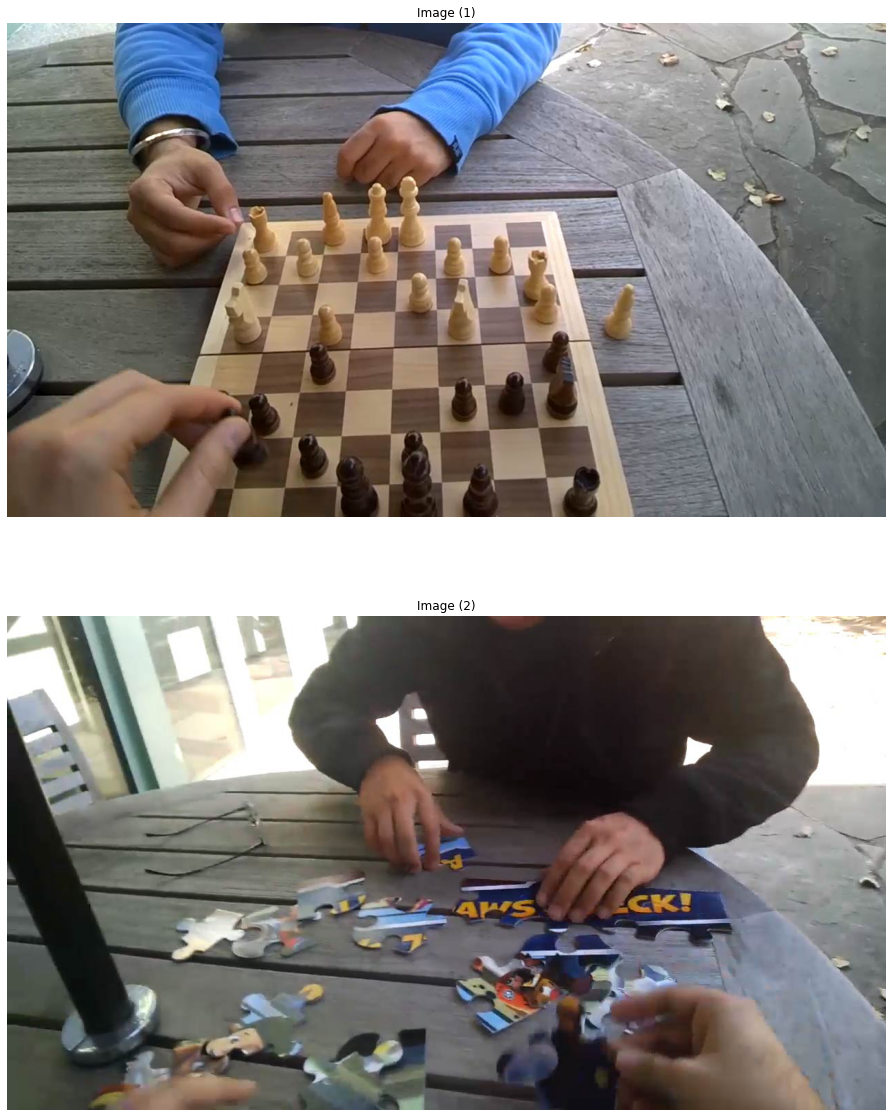

In [ ]:
### Display some example images
sample_paths=random.sample(df.img_path.to_list(),2)
sample_imgs=[]
for path in sample_paths:
  sample_imgs.append(imread(path))
show_images(sample_imgs,cols=2)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:0


#Dataset

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))
class hand_dataset(object):
    def __init__(self,df,bbox,transform=None):
        self.df=df
        self.transform=transform
        self.bbox=bbox
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        img=imread(self.df.iloc[idx,0])
        img=torch.tensor(np.array(img),dtype=torch.float32).permute(2,0,1)
        boxes=self.bbox[self.df.iloc[idx,2]:self.df.iloc[idx,2]+self.df.iloc[idx,1],:]
        boxes=boxes.reshape(self.df.iloc[idx,1],-1)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        num_objs=self.df.iloc[idx,1].astype(int)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target = {}
        target["boxes"] = boxes # bounding box 
        target["labels"] = labels # hand +background
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        return img,target

In [ ]:
ego_hand=hand_dataset(df=df,bbox=bbox)
lengths=[int(len(ego_hand)*0.7), int(len(ego_hand)*0.2),len(ego_hand)-int(len(ego_hand)*0.7)-int(len(ego_hand)*0.2)]
train_x,val_x,test_x=torch.utils.data.dataset.random_split(ego_hand,lengths=lengths)
train_dataloader= torch.utils.data.DataLoader(train_x, batch_size=2, shuffle=True,collate_fn=collate_fn,num_workers=2)
val_dataloader=   torch.utils.data.DataLoader(val_x, batch_size=2, shuffle=True,collate_fn=collate_fn)
test_dataloader=  torch.utils.data.DataLoader(test_x, batch_size=2, shuffle=True,collate_fn=collate_fn)
# data_loader= torch.utils.data.DataLoader(ego_hand, batch_size=2, shuffle=True,collate_fn=collate_fn)

# Finetuning Faster R-CNN

In [ ]:
# load a model pre-trained pre-trained on COCO
model = fasterrcnn_resnet50_fpn(pretrained=True)
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (hand) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device);

In [ ]:
for param in model.backbone.parameters():
  param.requires_grad = True
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.00001,weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

# Training

In [ ]:
def evaluation(model,test_dataloader,threshold=0.5,min_class_score=0.7):
  model.eval()
  TP,FP,FN=0,0,0
  mergin=1e-6
  for batch,(img,targets) in enumerate(test_dataloader):
    with torch.no_grad():
      img=list(i.to(device) for i in img)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      pred=model(img)
      for sample,dic in enumerate(pred):
          keep=torch.where(dic['scores']>=min_class_score)
          boxes=dic['boxes'][keep]
          if len(boxes):
            iou=torchvision.ops.box_iou(targets[sample]['boxes'],boxes)
            correct_detection=sum(torch.max(iou,axis=1).values>threshold)
            TP+=correct_detection
            FP+=len(boxes)-correct_detection
            FN+=targets[sample]['boxes'].size()[0]-correct_detection
          else:
            # TP=0
            FN+=targets[sample]['boxes'].size()[0]
            FP+=len(boxes)
  print(f"Precision:{TP/(TP+FP+mergin)} Recall:{TP/(TP+FN+mergin)}")  

In [ ]:
model.train()
num_epochs=20
best_val_loss=9999
loss_train_history= []
loss_valid_history= []

for epoch in range(num_epochs):
  print('\n--------------------------------------------------')
  print('Epoch: {} '.format(epoch))
  
  train_loss=0
  val_loss=0
  for batch,(img,targets) in enumerate(train_dataloader):
    img=list(i.to(device) for i in img)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(img,targets)
    losses = sum(loss for loss in loss_dict.values())
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    train_loss+=losses.detach().item()
  loss_train_history.append(train_loss/(batch+1))

  evaluation(model=model,test_dataloader=val_dataloader,threshold=0.5,min_class_score=0.7)
  print('--------------------------------------------------')
  model.train()

In [ ]:
len(train_dataloader)

In [ ]:
evaluation(model=model,test_dataloader=val_dataloader,threshold=0.5,min_class_score=0.7)

Precision:0.27906978130340576 Recall:0.5874125957489014


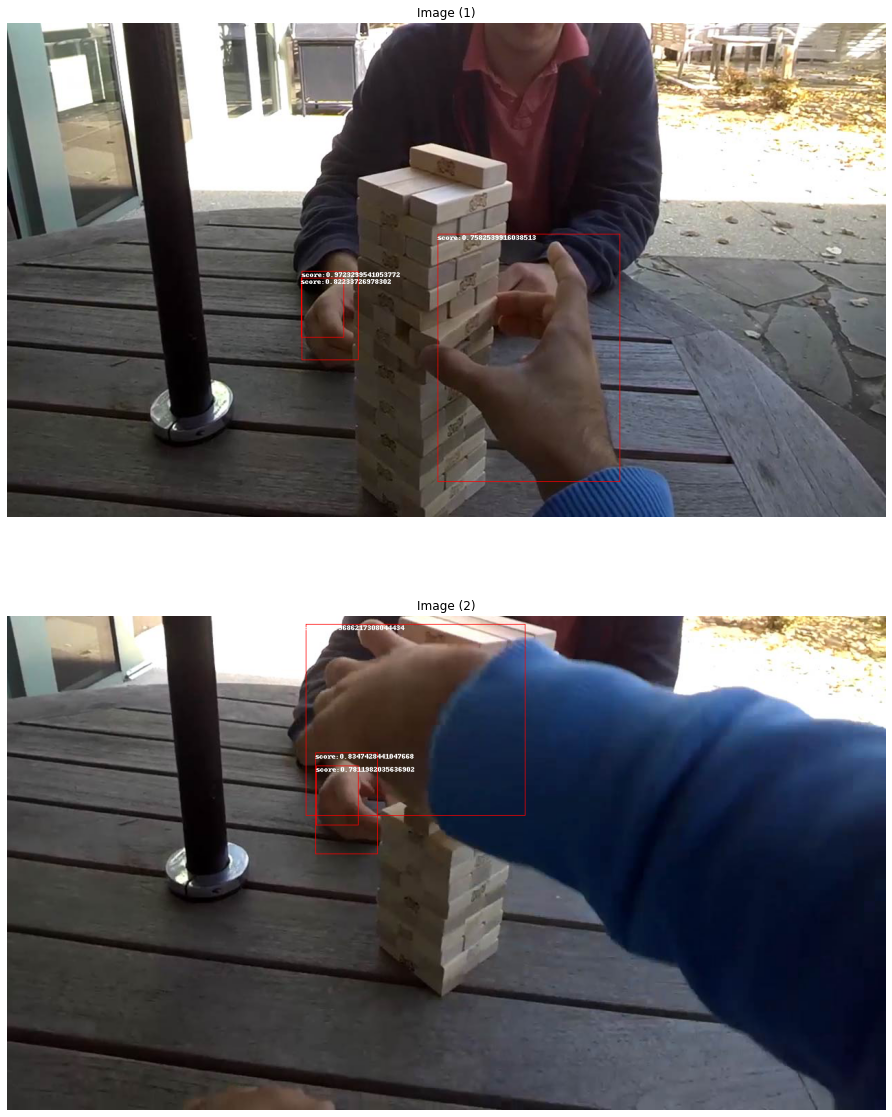

In [ ]:
### Demonstration purpose
img,targets=next(iter(test_dataloader))
img=list(i.to(device) for i in img)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
model.eval()
with torch.no_grad():
  pred=model(img)
imgs=[]
for i in range(len(pred)):
  img_id=targets[i]['image_id'].item()
  img_path=df['img_path'][img_id]
  keep=torch.where(pred[i]['scores']>=0.7)
  boxes=pred[i]['boxes'][keep]
  scores=pred[i]['scores'][keep]
  source_img=Image.open(img_path)  
  draw = ImageDraw.Draw(source_img,mode='RGB')
  for i in range(boxes.size()[0]):
    draw.rectangle(boxes[i,:].tolist(), fill=None,outline=(255,0,0))
    draw.text((boxes[i,0], boxes[i,1]), f"score:{scores[i]}")
  imgs.append(np.array(source_img))
show_images(imgs,cols=2)
